# Variogram, Kriging, Random Conditioned Example
In this Colab notebook:

- Variogram exploration & calculation
    - Which directions have highest spatial correlation?
- Kriging spatial interpolation
- Quasi-stochastic modeling
- 3D Kriging 
- 3D visualization with PyVista

Through all of this you'll be introduced to manipulating data and plotting with Python & Colab.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np
import pandas as pd

### Let's get some data. 
This command (notice the `!` is a system command so like you are in shell window) will put the file in your current colab directory (*not* your personal google drive)

`wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=FILEID' -O FILENAME4Saving`

In [4]:
# https://drive.google.com/file/d/1ylm9aAwu5FhsIJmYMRZ_FcRIX091Liqc/view?usp=sharing
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ylm9aAwu5FhsIJmYMRZ_FcRIX091Liqc' -O WGC_temp.csv

--2022-03-01 10:53:21--  https://docs.google.com/uc?export=download&id=1ylm9aAwu5FhsIJmYMRZ_FcRIX091Liqc
Resolving docs.google.com (docs.google.com)... 74.125.142.139, 74.125.142.101, 74.125.142.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h5mc055k0n5cb0rn7t9a2vb52kn45hd3/1646131950000/03887978596655340594/*/1ylm9aAwu5FhsIJmYMRZ_FcRIX091Liqc?e=download [following]
--2022-03-01 10:53:22--  https://doc-14-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h5mc055k0n5cb0rn7t9a2vb52kn45hd3/1646131950000/03887978596655340594/*/1ylm9aAwu5FhsIJmYMRZ_FcRIX091Liqc?e=download
Resolving doc-14-0o-docs.googleusercontent.com (doc-14-0o-docs.googleusercontent.com)... 74.125.197.132, 2607:f8b0:400e:c03::84
Connecting to doc-14-0o-docs.googleusercontent.com (doc-14-0o-docs.goog

You can see what's in the temporary Colab directory. Also see if you click the folder icon on the far left of your screen.

In [5]:
!ls -ltr 

total 8
drwxr-xr-x 1 root root 4096 Feb 18 14:33 sample_data
-rw-r--r-- 1 root root  830 Mar  1 10:53 WGC_temp.csv


Now we use some pandas to read the csv file into a DataFrame

In [6]:
temp_df = pd.read_csv('/content/WGC_temp.csv')

In [7]:
temp_df

,Unnamed: 0,x,y,z,temp
0,0,-254.058824,-2283.647059,0.0,9.5
1,1,-309.058824,-2740.647059,0.0,8.4
2,2,846.941176,-2166.647059,0.0,9.7
3,3,2179.941176,-1333.647059,0.0,8.2
4,4,1507.941176,-552.647059,0.0,9.0
5,5,593.941176,484.352941,0.0,9.8
6,6,116.941176,1497.352941,0.0,9.0
7,7,-639.058824,1085.352941,0.0,9.5
8,8,-791.058824,41.352941,0.0,10.0
9,9,136.941176,-784.647059,0.0,9.4


In [8]:
temp_df = temp_df.drop(columns='Unnamed: 0') # get rid of junk column
temp_df.head()

,x,y,z,temp
0,-254.058824,-2283.647059,0.0,9.5
1,-309.058824,-2740.647059,0.0,8.4
2,846.941176,-2166.647059,0.0,9.7
3,2179.941176,-1333.647059,0.0,8.2
4,1507.941176,-552.647059,0.0,9.0


Let's check the summary statistics of this little dataset

In [9]:
temp_df.describe()

,x,y,z,temp
count,1.700000e+01,1.700000e+01,17.0,17.000000
mean,1.369592e-11,3.834858e-10,0.0,9.052941
std,8.712811e+02,2.179169e+03,0.0,0.676496
min,-1.037059e+03,-2.740647e+03,0.0,7.600000
25%,-6.390588e+02,-2.166647e+03,0.0,8.500000
50%,-2.540588e+02,-5.526471e+02,0.0,9.200000
75%,2.119412e+02,1.497353e+03,0.0,9.500000
max,2.179941e+03,3.989353e+03,0.0,10.000000


Plot what it looks like in space

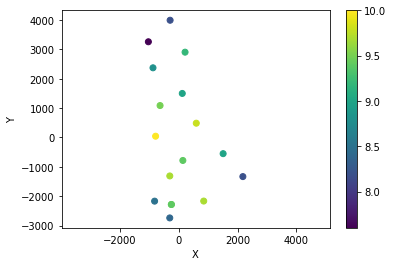

In [10]:
plt.scatter(temp_df['x'],temp_df['y'],c=temp_df['temp']) #,vmin=7, vmax=10)
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()

# Install packages for plotting and geostatistic tools

In [11]:
!pip install gstools

In [12]:
import gstools as gs

[PyVista](https://docs.pyvista.org/getting-started/installation.html) has awesome plotting tools. [GSTools](https://pypi.org/project/gstools/) is the library we will use to demonstrate some geostatistical concepts.



# Variogram calculation
First let's establish a variable of *where* the data is (position: `pos`) and the data value (value: `val`) which will be used for *conditioning* the geostatistical interpolation.

In [13]:
temp_cond_pos = [[temp_df.x], [temp_df.y]]
temp_cond_val = temp_df.temp
print(np.shape(temp_cond_val))
print(np.shape(temp_cond_pos))
temp_cond_pos

(17,)
(2, 1, 17)


[[0     -254.058824
  1     -309.058824
  2      846.941176
  3     2179.941176
  4     1507.941176
  5      593.941176
  6      116.941176
  7     -639.058824
  8     -791.058824
  9      136.941176
  10    -308.058824
  11    -825.058824
  12    -880.058824
  13   -1037.058824
  14     211.941176
  15    -297.058824
  16    -254.058824
  Name: x, dtype: float64], [0    -2283.647059
  1    -2740.647059
  2    -2166.647059
  3    -1333.647059
  4     -552.647059
  5      484.352941
  6     1497.352941
  7     1085.352941
  8       41.352941
  9     -784.647059
  10   -1311.647059
  11   -2169.647059
  12    2370.352941
  13    3256.352941
  14    2902.352941
  15    3989.352941
  16   -2283.647059
  Name: y, dtype: float64]]

## Angles: Radian
Let's compute the variabilty in directions.

We need the directions in radians, not angles.

In [14]:
myrads=np.radians([0,45,90,135,180]); myrads

array([0.        , 0.78539816, 1.57079633, 2.35619449, 3.14159265])

In [15]:
bin_center, gamma_0 = gs.vario_estimate((temp_cond_pos), temp_cond_val,angles=0) #cond_val, bins)
bin_center, gamma_45 = gs.vario_estimate((temp_cond_pos), temp_cond_val,angles=0.78539816)
bin_center, gamma_90 = gs.vario_estimate((temp_cond_pos), temp_cond_val,angles=1.57079633)
bin_center, gamma_135 = gs.vario_estimate((temp_cond_pos), temp_cond_val,angles=2.35619449)
bin_center, gamma_180 = gs.vario_estimate((temp_cond_pos), temp_cond_val,angles=3.14159265)
bin_center, gamma = gs.vario_estimate((temp_cond_pos), temp_cond_val)
#?gs.vario_estimate
print('gamma_0',gamma_0)
print('gamma_90',gamma_90)
print('gamma_135',gamma_135)
print('gamma_180',gamma_180)

gamma_0 [0.005  0.     0.4525 0.     0.0325 0.46   0.72   0.     0.72   0.5   ]
gamma_90 [0.005      0.5525     0.         0.26166667 0.125      0.247
 0.06166667 0.245      1.14333333 0.2175    ]
gamma_135 [0.005      0.         0.         0.005      0.33       0.09625
 0.045      0.         0.4925     0.59333333]
gamma_180 [0.005  0.     0.4525 0.     0.0325 0.46   0.72   0.     0.72   0.5   ]


## Which variogram is best to use?
This cell is looping through the different types of variograms which all have a bit of different behavior at different lag distances.

For example:
- $Exp(h) = 1 -exp(-3h/a)$
- $Sph(h) = 1.5(h/a) - 0.5(h/a)^3$ 
- $Gaus(h) = 1 -exp(-3(h/a)^2)$

Exponential(dim=2, var=0.296, len_scale=2.05e+02, nugget=0.05)
Spherical(dim=2, var=0.294, len_scale=4.28e+02, nugget=0.05)
Gaussian(dim=2, var=0.298, len_scale=1.9e+02, nugget=0.05)


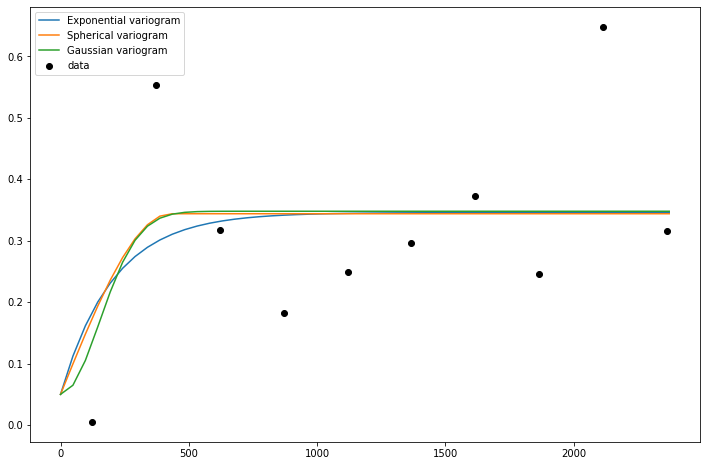

In [16]:
varmodeltypes = {
  "Exponential": gs.Exponential,
  "Spherical": gs.Spherical,
  "Gaussian": gs.Gaussian
}

scores = {}

plt.figure(figsize=(12,8))
# plot the estimated variogram
plt.scatter(bin_center, gamma, color="k", label="data")
ax = plt.gca()

# fit all models to the estimated variogram
for model in varmodeltypes:
    fit_model = varmodeltypes[model](dim=2)
    para, pcov, r2 = fit_model.fit_variogram(bin_center, gamma, return_r2=True,nugget=0.05)
    fit_model.plot(x_max=np.max(bin_center)+10, ax=ax)
    scores[model] = r2
    print(fit_model)

#### Which one of those fit the data best?


In [17]:
import operator
sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_scores)

[('Gaussian', 0.29214091293836997), ('Spherical', 0.2609393239092789), ('Exponential', 0.19242238271503176)]


The `Stable` variogram has the best `r^2` score, but I like the look of the Exponential, so that's what I'll try in the following cell.

In [18]:
vario_model = gs.Gaussian(dim=2) #Gaussian(dim=2)
vario_model_0 = gs.Gaussian(dim=2)
vario_model_90 =gs.Gaussian(dim=2)
vario_model_45 =gs.Gaussian(dim=2)
vario_model_135 =gs.Gaussian(dim=2)
vario_model_180 =gs.Gaussian(dim=2)

vario_model.fit_variogram(bin_center, gamma, nugget=0.05)
vario_model_0.fit_variogram(bin_center, gamma_0, nugget=0.05)
vario_model_90.fit_variogram(bin_center, gamma_90, nugget=0.05)
vario_model_45.fit_variogram(bin_center, gamma_45, nugget=0.05)
vario_model_135.fit_variogram(bin_center, gamma_135, nugget=0.05) 
vario_model_180.fit_variogram(bin_center, gamma_180, nugget=0.05) 

vario_model

Gaussian(dim=2, var=0.298, len_scale=1.9e+02, nugget=0.05)

Now let's plot the experimental variogram (raw from the data, scatter plot) and the modeled variogram.

Text(0.5, 1.0, 'Gaussian(dim=2, var=0.298, len_scale=1.9e+02, nugget=0.05) & Experimental variogram')

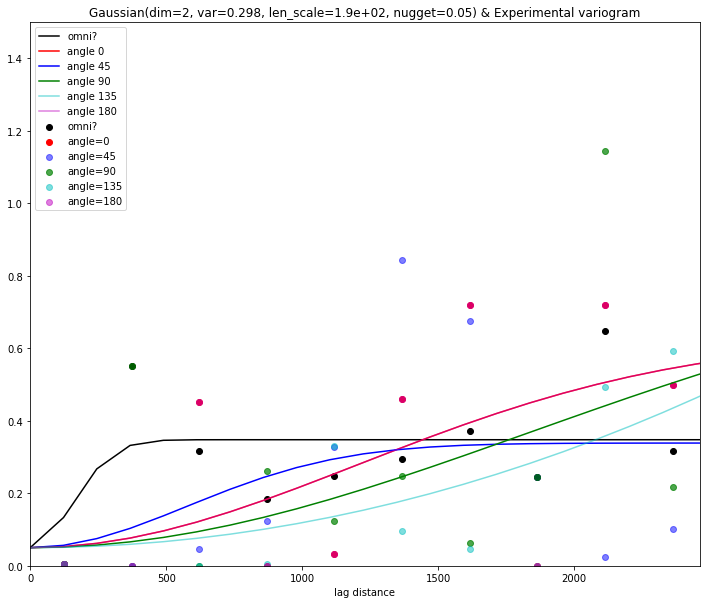

In [19]:
fig, axes = plt.subplots(figsize=(12,10))


x_plot_limit = 6000

vario_model.plot(x_max=x_plot_limit, c='k', label='omni?',ax=axes)
vario_model_0.plot(x_max=x_plot_limit, c='r', label='angle 0',ax=axes)
vario_model_45.plot(x_max=x_plot_limit, c='b', label='angle 45',ax=axes)
vario_model_90.plot(x_max=x_plot_limit, c='g', label='angle 90',ax=axes)
vario_model_135.plot(x_max=x_plot_limit, c='c', label='angle 135',ax=axes,alpha=0.5)
vario_model_180.plot(x_max=x_plot_limit, c='m', label='angle 180',ax=axes,alpha=0.5)

axes.scatter(bin_center, gamma,c='k', label='omni?')
axes.scatter(bin_center, gamma_0,c='r', label='angle=0')
axes.scatter(bin_center, gamma_45,c='b',label='angle=45',alpha=0.5)
axes.scatter(bin_center, gamma_90,c='g',label='angle=90',alpha=0.7)
axes.scatter(bin_center, gamma_135,c='c',label='angle=135',alpha=0.5)
axes.scatter(bin_center, gamma_180,c='m',label='angle=180',alpha=0.5)
axes.legend()
axes.set_xlabel('lag distance')
axes.set_xlim([0, np.max(bin_center)+100])
axes.set_ylim([0, 1.5])
axes.set_title(str(vario_model)+' & Experimental variogram')

Now that we know from plot above, which direction has highest correlation, we can re-calculate the variogram with these angles as the principal axis.

| Degree  | Radians  |
|:-:|:-:|
| 0  | 0  |
| 45  | 0.78539816  |
| 90  | 1.57079633  |
| 135  | 2.35619449  |
| 180  | 3.14159265  |

In [20]:
vario_model_0, vario_model_90

(Gaussian(dim=2, var=0.579, len_scale=1.51e+03, nugget=0.05),
 Gaussian(dim=2, var=0.806, len_scale=2.3e+03, nugget=0.05))

In [21]:
vario_model_Krige = vario_model_90

In [22]:
bin_center, dir_vario, counts = gs.vario_estimate(
*((temp_cond_pos), temp_cond_val),
direction=gs.rotated_main_axes(dim=2, angles=1.57),
#angles_tol=np.pi / 8,
#bandwidth=8,
return_counts=True,
)

Counts tells us how many pairs of data points meet each distance criteria (both in angle and distance magnitude).

In [23]:
counts

array([[1, 2, 0, 3, 1, 5, 3, 1, 3, 6],
       [0, 0, 2, 0, 2, 3, 1, 0, 1, 1]])

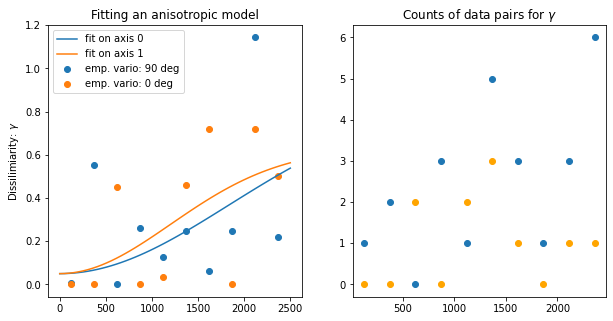

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 5])
ax1.scatter(bin_center, dir_vario[0], label="emp. vario: 90 deg")
ax1.scatter(bin_center, dir_vario[1], label="emp. vario: 0 deg")
ax1.legend(loc="lower right")
vario_model_90.plot("vario_axis", axis=0, ax=ax1, x_max=2500, label="fit on axis 0")
vario_model_0.plot("vario_axis", axis=1, ax=ax1, x_max=2500, label="fit on axis 1")
ax1.set_title("Fitting an anisotropic model")
ax1.set_ylabel('Dissilimiarity: $\gamma$')

ax2.scatter(bin_center, counts[0],label='135 deg')
ax2.scatter(bin_center, counts[1],color='orange',label='45 deg')
ax2.set_title('Counts of data pairs for $\gamma$')
plt.show()

# 2D Kriging: spatial interpolation with the $\gamma$ 

First, define the regular grid on which the interpolation will be done. Check how big it is.

In [25]:
gridx = np.arange(np.min(temp_df.x)-500, np.max(temp_df.x)+500,10)
gridy = np.arange(np.min(temp_df.y)-500, np.max(temp_df.y)+500,10)
np.shape(gridx), np.shape(gridy)

((422,), (773,))

In [27]:
normalizer= gs.normalizer.LogNormal(temp_cond_val) #gs.normalizer.LogNormal, BoxCox, , YeoJohnson,Modulus, John-Draper (1980), Manly (page 102/96)
myFitNormalizer = True

# fit_variogram= Already done, normalizer=normalizer, fit_normalizer=myFitNormalizer,
krigeOK = gs.krige.Ordinary(vario_model_Krige, cond_pos=temp_cond_pos, cond_val=temp_cond_val, exact=True) 
krigeOK.structured((gridx, gridy))

print('made with this variogram model: ',vario_model_Krige)
np.shape(krigeOK.field)


/usr/local/lib/python3.7/dist-packages/gstools/normalizer/base.py:222: UserWarning: LogNormal.fit: no parameters!
  warnings.warn(f"{self.name}.fit: no parameters!")


made with this variogram model:  Gaussian(dim=2, var=0.806, len_scale=2.3e+03, nugget=0.05)


(422, 773)

In [28]:
import mpl_toolkits.axisartist.floating_axes as floating_axes

Text(0.5, 0.98, 'Gaussian(dim=2, var=0.298, len_scale=1.9e+02, nugget=0.05)$\\gamma$ model')

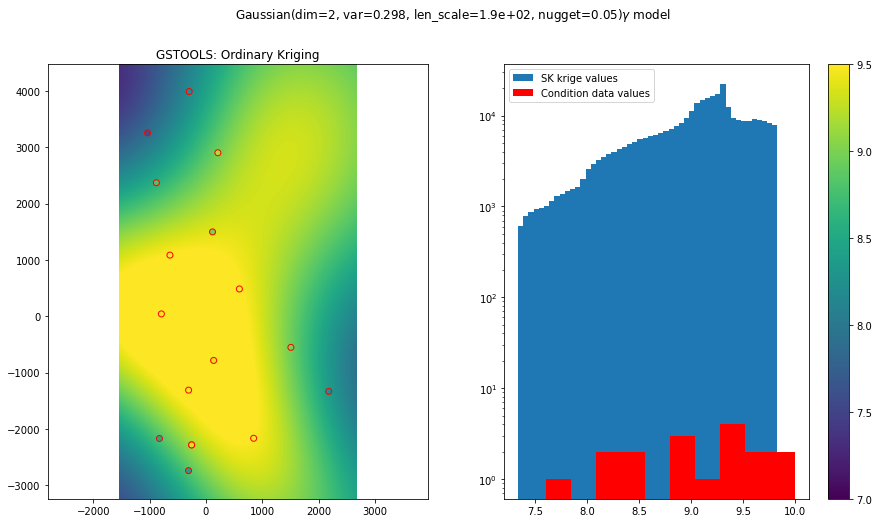

In [29]:
my_vmin = 7 # 10
my_vmax = 9.5 #90

f, myax = plt.subplots(figsize=[15, 8], nrows=1, ncols=2)
myax = myax.flatten()
# plot the result
phandle =myax[0].pcolormesh(gridx,gridy,krigeOK.field.T,shading='auto',vmin=my_vmin, vmax=my_vmax,clip_on=True)
myax[0].scatter(temp_cond_pos[0][0][:],temp_cond_pos[1][0][:],c=temp_cond_val,edgecolors='r', vmin=my_vmin, vmax=my_vmax)
myax[0].set_title('GSTOOLS: Ordinary Kriging')
myax[0].axis('equal')
cb = plt.colorbar(phandle)

myax[1].hist(krigeOK.field.flatten(),50,label='SK krige values')
myax[1].hist(temp_cond_val,color='red',label='Condition data values')
myax[1].set_yscale('log')
myax[1].legend()

plt.suptitle(str(vario_model)+'$\gamma$ model')

# Conditioned Random Field
Like Stochastic generation 

In [30]:
cond_srf = gs.CondSRF(krigeOK)
cond_srf

CondSRF(krige=Ordinary(model=Gaussian, cond_no=17), generator=RandMeth)

In [31]:
ens_no = 4
field = []
for i in range(ens_no): 
    field.append(cond_srf.structured([gridx, gridy],seed=i+49))

For plotting purposes, get the conditioning data on same scale as conditioned randome field.

In [32]:
# conditioning data on grid values
condgrid_x = np.floor((temp_df.x-np.min(gridx))/10)
condgrid_y = np.floor((temp_df.y-np.min(gridy))/10)

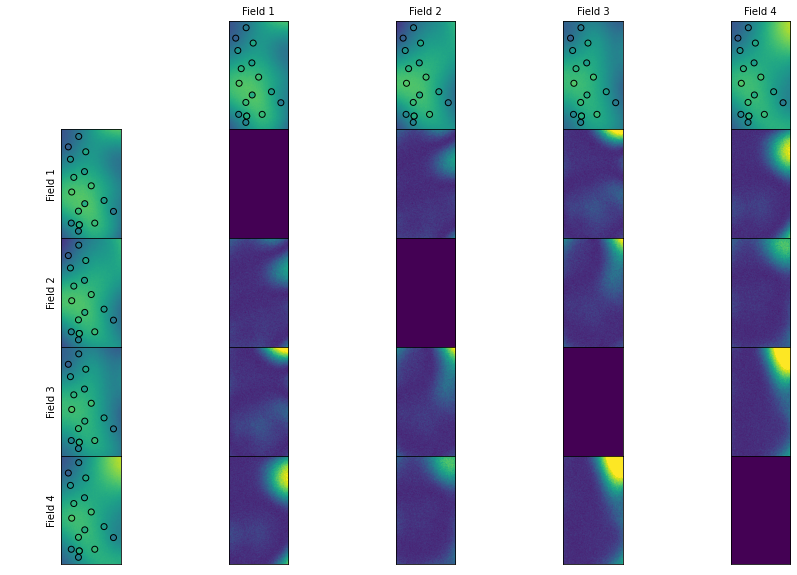

In [33]:
fig, ax = plt.subplots(ens_no + 1, ens_no + 1, figsize=(15, 10))
# plotting kwargs for scatter and image
sc_kwargs = dict(c=temp_cond_val, edgecolors="k", vmin=np.min(field), vmax=np.max(field))

#extent : floats (left, right, bottom, top), optional extent=2 * [0, 5], 
im_kwargs = dict(extent=[-0.5, np.shape(field)[1]-0.5,0,np.shape(field)[2]], origin="lower", vmin=np.min(field), vmax=np.max(field))
im_kwargs2 = dict(extent=[-0.5, np.shape(field)[1]-0.5,0,np.shape(field)[2]], origin="lower", vmin=0, vmax=2)

for i in range(ens_no):
      # conditioned fields and conditions
    ax[i + 1, 0].imshow(field[i].T , **im_kwargs)
    ax[i + 1, 0].scatter(condgrid_x,condgrid_y, **sc_kwargs)
    ax[i + 1, 0].set_ylabel(f"Field {i+1}", fontsize=10)
    ax[0, i + 1].imshow(field[i].T, **im_kwargs)
    ax[0, i + 1].scatter(condgrid_x,condgrid_y, **sc_kwargs)
    ax[0, i + 1].set_title(f"Field {i+1}", fontsize=10)
    # absolute differences
    for j in range(ens_no):
        ax[i + 1, j + 1].imshow(np.abs(field[i] - field[j]).T, **im_kwargs2)

# beautify plots
ax[0, 0].axis("off")
for a in ax.flatten():
    a.set_xticklabels([]), a.set_yticklabels([])
    a.set_xticks([]), a.set_yticks([])
    
fig.subplots_adjust(wspace=0, hspace=0)
fig.show()

Closer look

In [34]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

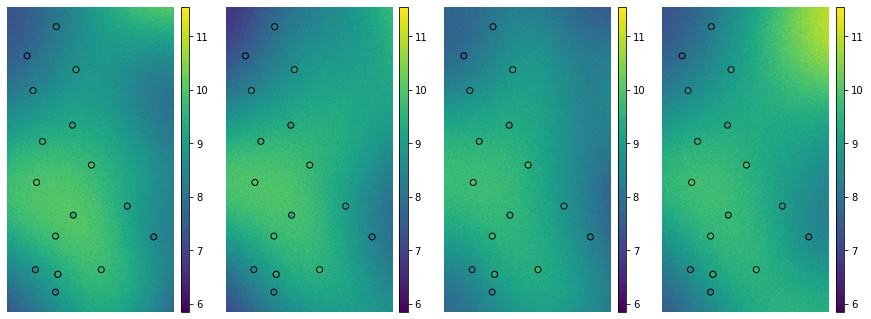

In [35]:
fig, axes = plt.subplots(ncols=4, figsize=(15,10))
axes = axes.flatten()

for i in range(ens_no):
    phandle = axes[i].imshow(field[i].T,**im_kwargs)
    axes[i].scatter(condgrid_x,condgrid_y, c=temp_cond_val, edgecolors="k", vmin=np.min(field), vmax=np.max(field))
    axes[i].axis('equal')
    axes[i].set_axis_off()
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cb = plt.colorbar(phandle,cax=cax)

# 3D Kriging for demonstration purposes

This data is actually from 2m probes (hence so low), but let's add some fake z data so you can see 3D Kriging and visualization with PyVista.

Here's an example of a function:

In [36]:
import scipy.stats

Generate some random numbers, from a distribution that has a mean of 100, standard deviation of 30. We want as many fake z's as there are x's in our data (`len(temp_df.x)`)

In [37]:
fake_z = scipy.stats.norm.rvs(100, 10, size=len(temp_df.x)) 
fake_z

array([111.92698023,  84.35562895,  78.73782791,  82.09805803,
        91.62226057,  94.11149851, 105.47385082,  96.64001141,
        98.5000233 , 105.49609333, 115.97575439,  88.61310403,
       113.6851162 , 107.66411851, 106.66629795, 103.47460463,
        79.46536108])

In [38]:
temp_df.z = fake_z

Make a new grid so that it's not too big...

In [39]:
gridx = np.arange(np.min(temp_df.x), np.max(temp_df.x),200); print(np.shape(gridx))
gridy = np.arange(np.min(temp_df.y), np.max(temp_df.y),200); print(np.shape(gridy))
gridz = np.arange(np.min(temp_df.z), np.max(temp_df.z),10); print(np.shape(gridz))


(17,)
(34,)
(4,)


Re-fit variogram in 3d.

In [40]:
temp_cond_pos_3d = [[temp_df.x], [temp_df.y], [temp_df.z]]

In [41]:
bin_center_3d, dir_vario_3d, counts_3d = gs.vario_estimate(
*((temp_cond_pos_3d), temp_cond_val),
direction=gs.rotated_main_axes(dim=3, angles=1.57),
#angles_tol=np.pi / 8,
#bandwidth=8,
return_counts=True,
)

In [42]:
vario_model_3d = gs.Gaussian(dim=3, len_scale=[2300, 1600], angles=1.57) 
print("Original:")
print(vario_model_3d)
vario_model_3d.fit_variogram(bin_center_3d, dir_vario_3d) #, nugget=True)

Original:
Gaussian(dim=3, var=1.0, len_scale=2.3e+03, nugget=0.0, anis=[0.696, 0.696], angles=[1.57, 0.0, 0.0])


({'anis': array([8.32634472e-01, 6.91644689e+04]),
  'len_scale': 1804.6448338300481,
  'nugget': 0.03363645428443836,
  'var': 0.607712333873642},
 array([[ 2.00400655e-01,  4.82401289e+02,  3.26554375e-03,
          3.93030078e-02,  0.00000000e+00],
        [ 4.82401289e+02,  1.48004935e+06,  2.75484998e+01,
         -7.40382278e+00,  0.00000000e+00],
        [ 3.26554375e-03,  2.75484998e+01,  3.99119555e-03,
          5.74907805e-04,  0.00000000e+00],
        [ 3.93030078e-02, -7.40382278e+00,  5.74907805e-04,
          9.75051065e-02,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00]]))

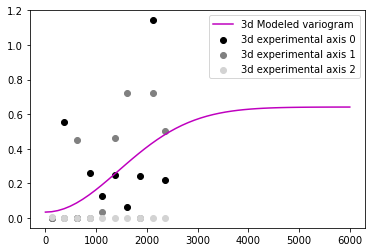

In [43]:
vario_model_3d.plot(x_max=6000, c='m', label='3d Modeled variogram') #,ax=axes[0],alpha=0.5)
plt.scatter(bin_center_3d, dir_vario_3d[0],c='k', label='3d experimental axis 0') 
plt.scatter(bin_center_3d, dir_vario_3d[1],c='gray', label='3d experimental axis 1') 
plt.scatter(bin_center_3d, dir_vario_3d[2],c='lightgray', label='3d experimental axis 2') 
plt.legend()

In [44]:
pos3 = [temp_df.x.values,temp_df.y.values,temp_df.z.values] # X Y Z
field3 = temp_df.temp # temperature
print(np.shape(pos3),np.shape(field3))
normalizer = gs.normalizer.LogNormal
krige = gs.krige.Ordinary(vario_model_3d, pos3, field3)#, normalizer=normalizer)
krige.structured((gridx, gridy, gridz))
print('size of kriging estimate',krige.field.shape)

(3, 17) (17,)
size of kriging estimate (17, 34, 4)


## Stuff to let PyVista work on colab

In [45]:
# setup enviornment for interactive plotting
!apt-get install -qq xvfb
!pip install pyvista panel -q

import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

import panel as pn
pn.extension('vtk')


In [46]:
!pip install -q piglet pyvirtualdisplay
!pip install -q pyvista
!apt-get -qq install xvfb


In [47]:

# new cell
from pyvirtualdisplay import Display
display = Display(visible=0, size=(600, 400))
display.start()



Just a test of the display (nothing from our data or modeling)

In [48]:
# new cell
import pyvista as pv
sphere = pv.Sphere()
# short example
sphere.plot(notebook=True, window_size=(600,400))


ViewInteractiveWidget(height=400, layout=Layout(height='auto', width='100%'), width=600)

## Putting the 3d kriging values into PyVista object

In [56]:
# https://docs.pyvista.org/examples/00-load/create-uniform-grid.html
values = krige.field

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape + 1 because we want to inject our values on
#   the CELL data
grid.dimensions = np.array(values.shape) + 1

# Edit the spatial reference
grid.origin = (100, 33, 55.6)  # The bottom left corner of the data set
grid.spacing = (1, 5, 2)  # These are the cell sizes along each axis

# Add the data values to the cell data
grid.cell_arrays["values"] = values.flatten(order="F")  # Flatten the array!


/usr/local/lib/python3.7/dist-packages/pyvista/core/dataset.py:1544: PyvistaDeprecationWarning: Use of `cell_arrays` is deprecated. Use `cell_data` instead.
  PyvistaDeprecationWarning


Now plotting!

In [50]:
!pip install ipyvtklink

In [51]:
from google.colab import output
output.enable_custom_widget_manager()

In [57]:
# Now plot the grid!
grid.plot(notebook=True, window_size=(600,400),show_edges=False) #show_bounds=True,notebook=True, 

ViewInteractiveWidget(height=400, layout=Layout(height='auto', width='100%'), width=600)

# More resources

If you are familiar with Scikit-Learn
- scikit-gstat: A scipy flavoured geostatistical variogram analysis toolbox
    - `!pip install scikit-gstat`

If you have Microsoft operation system (not a Mac or Linux), you can try 
- [Stanford Geostatistcal Modeling Software- SGEMS](http://sgems.sourceforge.net/)
    - has SGSIM, multiple point geostatistics, indicator kriging/simulation, etc.
- [PyGeostat](http://www.ccgalberta.com/pygeostat/installation.html)
    - calls GSLib functions

GeostatsPy also calls GSLib functions but has work arounds for Mac's.
- [GeostatsPy](https://www.michaelpyrcz.com/my-python-package.html)
    


